# 1D Spatial Model: open on both ends

Goal: Compare mean trajectories and time to takeover distribution for delta distributed division times and exponentially distributed division times

In [1]:
import numpy as np
import random as rand
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class cell:
    def __init__(self,index,parent,birth,init_plasmid,tau):
        '''Initializes cell attributes
        param:: index: cell index
        param:: parent: index of parent cell
        param:: birth: birth time
        param:: init_plasmid: plasmids partitioned to cell at birth
        param:: tau: growth rate
        return:: None
        '''
        self.index=index
        self.parent = parent
        self.birth = birth
        self.init_plasmid = init_plasmid
        self.ss_plasmid = 100 #placeholder number; will calculate steady state plasmid number later
        self.div = birth+tau+np.random.normal(0,.001)
        self.tau = tau

class cell_exp:
    def __init__(self,index,parent,birth,init_plasmid,tau):
        '''Initializes cell attributes
        param:: index: cell index
        param:: parent: index of parent cell
        param:: birth: birth time
        param:: init_plasmid: plasmids partitioned to cell at birth
        param:: tau: growth rate
        return:: None
        '''
        self.index=index
        self.parent = parent
        self.birth = birth
        self.init_plasmid = init_plasmid
        self.ss_plasmid = 100 #placeholder number; will calculate steady state plasmid number later
        self.div = birth+np.random.exponential(scale = tau/np.log(2), size=None)
        self.tau = tau

class cell_loc:
    def __init__(self,index,parent,birth,init_plasmid,tau,loc):
        '''Initializes cell attributes
        param:: index: cell index
        param:: parent: index of parent cell
        param:: birth: birth time
        param:: init_plasmid: plasmids partitioned to cell at birth
        param:: tau: growth rate
        param:: loc: location of cell in 1D column
        return:: None
        '''
        self.index = index
        self.parent = parent
        self.birth = birth
        self.init_plasmid = init_plasmid
        self.ss_plasmid = 100 #placeholder number; will calculate steady state plasmid number later
        self.div = birth+tau+np.random.normal(0,.001)
        self.loc = loc
        self.tau = tau

class cell_locexp:
    def __init__(self,index,parent,birth,init_plasmid,tau,loc):
        '''Initializes cell attributes
        param:: index: cell index
        param:: parent: index of parent cell
        param:: birth: birth time
        param:: init_plasmid: plasmids partitioned to cell at birth
        param:: tau: growth rate
        param:: loc: location of cell in 1D column
        return:: None
        '''
        self.index=index
        self.parent = parent
        self.birth = birth
        self.init_plasmid = init_plasmid
        self.ss_plasmid = 100 #placeholder number; will calculate steady state plasmid number later
        self.div = birth+np.random.exponential(scale = tau/np.log(2), size=None)
        self.loc = loc
        self.tau = tau

def count_plasmid_cells(Q):
    cells_with_plasmids = 0
    cells_without_plasmids = 0

    for cell in Q:
        if cell.init_plasmid > 0:
            cells_with_plasmids += 1
        else:
            cells_without_plasmids += 1
    
    return cells_with_plasmids, cells_without_plasmids

In [16]:
# Spatial model with delta distributed division times
#### Main differences from above simulation: 
####  - keep track of cell location when creating cells
####  - update cell locations when a cell divides - all cells to right of dividing cell get pushed over one
####  - cell removal: cell with highest location index gets removed

def simulation_spatial_delta(Nmax, keep, a_w, a_m, n, p):
    countloss=0 #Count number of division resulting in plasmid loss
    countplas=0 #Count number of plasmid containing cells that divide
    init_plasmid=1 #initial plasmid number of first cell. Arbitrary- just can't be 0
    #c= cell(0,[],0,init_plasmid,a_w)   #cell(index,parent,birth,initialplasmid,tau)
    
    cells_with_plasmids_history = []
    cells_without_plasmids_history = []
    losstimes=[]
    divisiontimes=[]

    Q=[] # initialize queue of cells that have not divided yet (currently alive cells)
    for i in range(keep):
        Q.append(cell_loc(i, [], 0, init_plasmid, np.random.uniform(0,a_w),i)) #cell(index,parent,birth,initialplasmid,tau)
        #note: division time = birth + tau. 
        #I initialize cells so they will divide at some point between 0 and a_w time units in the future
        #so for the initialized cells, their age at the begining of the simulation is a_w - Q[i].div
   
    cells=[] #list of cells that have divided already
    N=keep-1 #indices taken by initialized cell population

    while len(cells)<Nmax:
        
    
                    
        ######## Delta distrubuted division times: sort by age; everyone divides when they reach age tau
        
        #sort Q so Q[0] is next cell to divide
        Q=sorted(Q,key=lambda x: x.div, reverse=False)
        
        #assign current cell to simulate
        current=Q[0]
        divisiontimes.extend([current.div])
        #Calculate steady state plasmid number
        if current.init_plasmid==0:
            d1_plasmids=0
            d2_plasmids=0
        else:
            countplas=countplas+1
            ss_plasmid_num=np.random.binomial(n,p,size=None)
            current.ss_plasmid=ss_plasmid_num

            #Partition plasmids between two daughter cells
            d1_plasmids=np.random.binomial(ss_plasmid_num,p,size=None)
            d2_plasmids=ss_plasmid_num-d1_plasmids
            if d1_plasmids == 0 or d2_plasmids == 0:
                countloss=countloss+1
                losstimes.extend([current.div])

        

        #Create two new daughter cells
        if d1_plasmids==0:
            daughter1=cell_loc(N+1, current.index, current.div, d1_plasmids, a_m, current.loc) #index,parentindex,birth,initialplasmids,tau
        else:
            daughter1=cell_loc(N+1, current.index, current.div, d1_plasmids, a_w, current.loc) #index,parentindex,birth,initialplasmids,tau
        
        #######################################
        ## Calculate probablility that daughter 2 goes to the right of current (daughter 1 takes location of current)
        # Probability of 50% regardless of location:
        prob_right=np.random.binomial(1,(keep-2)/(keep*(keep-1))*current.loc+1/keep, size=None)
        # if d2 is on the right:
        if prob_right==1:
            if d2_plasmids==0:
                daughter2=cell_loc(N+2, current.index, current.div, d2_plasmids, a_m, current.loc+1) #index,parentindex,birth,initialplasmids,tau
            else:
                daughter2=cell_loc(N+2, current.index, current.div, d2_plasmids, a_w, current.loc+1) #index,parentindex,birth,initialplasmids,tau
            #####Update locations in Q to represent daughter cells pushing other cells to the right
            for i in Q:
                if i.loc > current.loc: #current.loc+1 or greater
                    i.loc=i.loc+1       #becomes loc+2 or greater
            #Update Q for next time - remove current cell, add daughter cells
            Q.remove(current)
            Q.extend([daughter1,daughter2]) #add daughters with locations current.loc, current.loc+1

            #####Remove cell with rightmost location (includes daughter cells - this might introduce discrepancy from previous simulation)
            remove=max(Q,key=lambda x: x.loc)
            new_Q = [x for x in Q if x != remove]
            Q = new_Q.copy()
        # if d2 is on the left:
        else:
            if d2_plasmids==0:
                daughter2=cell_loc(N+2, current.index, current.div, d2_plasmids, a_m, current.loc-1) #index,parentindex,birth,initialplasmids,tau
            else:
                daughter2=cell_loc(N+2, current.index, current.div, d2_plasmids, a_w, current.loc-1) #index,parentindex,birth,initialplasmids,tau
            #####Update locations in Q to represent daughter cells pushing other cells to the left
            for i in Q:
                if i.loc < current.loc: #current.loc-1 or less
                    i.loc=i.loc-1       #becomes loc-2 or less
            #Update Q for next time - remove current cell, add daughter cells
            Q.remove(current)
            Q.extend([daughter1,daughter2]) #add daughters with locations current.loc, current.loc-1

            #####Remove cell with leftmost location (includes daughter cells - this might introduce discrepancy from previous simulation)
            remove=min(Q,key=lambda x: x.loc)
            new_Q = [x for x in Q if x != remove]
            Q = new_Q.copy()

        #Add current cell to vector 'cells'
        cells.extend([current])

        
        
        
        ########
        # Count the number of cells with and without plasmids in the current population
        cells_with_plasmids, cells_without_plasmids = count_plasmid_cells(Q)

        #Record time of plasmid free population takeover
        if len(cells_without_plasmids_history)>0:
            if cells_without_plasmids==keep:
                if cells_without_plasmids_history[-1]!=keep:
                    takeover_time=current.div
            else:
                takeover_time=100000 #placeholder to show that the plasmid free population did not take over

        # Append the current counts to the history lists
        cells_with_plasmids_history.append(cells_with_plasmids)
        cells_without_plasmids_history.append(cells_without_plasmids)

        #Update index for next time
        N+=2

        
        
    return Q, cells, cells_with_plasmids_history, cells_without_plasmids_history, countloss, countplas, losstimes, divisiontimes, takeover_time

In [17]:
# Spatial model with exponentially distributed division times
#### Only difference from other mother machiene simulation is the division time distribution

def simulation_spatial_exp(Nmax, keep, a_w, a_m, n, p):
    countloss=0 #Count number of division resulting in plasmid loss
    countplas=0 #Count number of plasmid containing cells that divide
    init_plasmid=1 #initial plasmid number of first cell. Arbitrary- just can't be 0
    #c= cell(0,[],0,init_plasmid,a_w)   #cell(index,parent,birth,initialplasmid,tau)
    
    cells_with_plasmids_history = []
    cells_without_plasmids_history = []
    losstimes=[]
    divisiontimes=[]

    Q=[] # initialize queue of cells that have not divided yet (currently alive cells)
    for i in range(keep):
        Q.append(cell_locexp(i, [], 0, init_plasmid, a_w,i)) #cell(index,parent,birth,initialplasmid,tau,loc)
        #note: division time = birth + tau, but this is updated once each cell is processed for this version. 
        #I initialize cells so they all divide with tau = wild type rate at first
   
    cells=[] #list of cells that have divided already
    N=keep-1 #indices taken by initialized cell population
    t=0
    while len(cells)<Nmax:
        
        ######## Exponentially distrubuted division times: sort by age; everyone divides when they reach age tau+sample from exp dist
        
        #sort Q so Q[0] is next cell to divide
        Q=sorted(Q,key=lambda x: x.div, reverse=False)
        
        #assign current cell to simulate
        current=Q[0]
        
    
        divisiontimes.extend([current.div])

        #Calculate steady state plasmid number
        if current.init_plasmid==0:
            d1_plasmids=0
            d2_plasmids=0
        else:
            countplas=countplas+1
            ss_plasmid_num=np.random.binomial(n,p,size=None)
            current.ss_plasmid=ss_plasmid_num

            #Partition plasmids between two daughter cells
            d1_plasmids=np.random.binomial(ss_plasmid_num,p,size=None)
            d2_plasmids=ss_plasmid_num-d1_plasmids
            if d1_plasmids == 0 or d2_plasmids == 0:
                countloss=countloss+1
                losstimes.extend([current.div])

        

        #Create two new daughter cells
        if d1_plasmids==0:
            daughter1=cell_locexp(N+1, current.index, current.div, d1_plasmids, a_m, current.loc) #index,parentindex,birth,initialplasmids,tau
        else:
            daughter1=cell_locexp(N+1, current.index, current.div, d1_plasmids, a_w, current.loc) #index,parentindex,birth,initialplasmids,tau
        
        #######################################
        ## Calculate probablility that daughter 2 goes to the right of current (daughter 1 takes location of current)
        # Probability of 50% regardless of location:
        prob_right=np.random.binomial(1,(keep-2)/(keep*(keep-1))*current.loc+1/keep, size=None)
        # if d2 is on the right:
        if prob_right==1:
            if d2_plasmids==0:
                daughter2=cell_locexp(N+2, current.index, current.div, d2_plasmids, a_m, current.loc+1) #index,parentindex,birth,initialplasmids,tau
            else:
                daughter2=cell_locexp(N+2, current.index, current.div, d2_plasmids, a_w, current.loc+1) #index,parentindex,birth,initialplasmids,tau
            #####Update locations in Q to represent daughter cells pushing other cells to the right
            for i in Q:
                if i.loc > current.loc: #current.loc+1 or greater
                    i.loc=i.loc+1       #becomes loc+2 or greater
            #Update Q for next time - remove current cell, add daughter cells
            Q.remove(current)
            Q.extend([daughter1,daughter2]) #add daughters with locations current.loc, current.loc+1

            #####Remove cell with rightmost location (includes daughter cells - this might introduce discrepancy from previous simulation)
            remove=max(Q,key=lambda x: x.loc)
            new_Q = [x for x in Q if x != remove]
            Q = new_Q.copy()
        # if d2 is on the left:
        else:
            if d2_plasmids==0:
                daughter2=cell_locexp(N+2, current.index, current.div, d2_plasmids, a_m, current.loc-1) #index,parentindex,birth,initialplasmids,tau
            else:
                daughter2=cell_locexp(N+2, current.index, current.div, d2_plasmids, a_w, current.loc-1) #index,parentindex,birth,initialplasmids,tau
            #####Update locations in Q to represent daughter cells pushing other cells to the left
            for i in Q:
                if i.loc < current.loc: #current.loc-1 or less
                    i.loc=i.loc-1       #becomes loc-2 or less
            #Update Q for next time - remove current cell, add daughter cells
            Q.remove(current)
            Q.extend([daughter1,daughter2]) #add daughters with locations current.loc, current.loc-1

            #####Remove cell with leftmost location (includes daughter cells - this might introduce discrepancy from previous simulation)
            remove=min(Q,key=lambda x: x.loc)
            new_Q = [x for x in Q if x != remove]
            Q = new_Q.copy()

        #Add current cell to vector 'cells'
        cells.extend([current])
        
        ########
        # Count the number of cells with and without plasmids in the current population
        cells_with_plasmids, cells_without_plasmids = count_plasmid_cells(Q)

        # Record time of plasmid free population takeover
        if len(cells_without_plasmids_history)>0:
            if cells_without_plasmids==keep:
                if cells_without_plasmids_history[-1]!=keep:
                    takeover_time=current.div
            else:
                takeover_time=100000 #placeholder to show that the plasmid free population did not take over

        # Append the current counts to the history lists
        cells_with_plasmids_history.append(cells_with_plasmids)
        cells_without_plasmids_history.append(cells_without_plasmids)

        #Update index for next time
        N+=2

        
        
    return Q, cells, cells_with_plasmids_history, cells_without_plasmids_history, countloss, countplas, losstimes, divisiontimes, takeover_time

In [23]:
Nmax=30000 #number of cells processed by simulation
keep=1000
#a_w=1.6 #Tx=wild type mean lifetime (note: the population with the shorter lifetime has the advantage)
#a_m=2 #Ty= plasmid free mean lifetime
a_w=1
a_m=1
n=10 #max number of plasmids
p=.5 #probability of success in binomial distribution; used to calculate steady state plasmid num and also 
     #daughter plasmid partitioning


In [24]:
Qloc, cellsloc,cells_with_plasmids_historyloc, cells_without_plasmids_historyloc,countlossloc,countplasloc,losstimesloc,divisiontimesloc, timeloc = simulation_spatial_delta(Nmax, keep, a_w, a_m, n, p)
Qlocexp, cellslocexp,cells_with_plasmids_historylocexp, cells_without_plasmids_historylocexp,countlosslocexp,countplaslocexp,losstimeslocexp,divisiontimeslocexp, timelocexp = simulation_spatial_exp(Nmax, keep, a_w, a_m, n, p)


In [25]:
em_plossloc=countlossloc/countplasloc
print(em_plossloc)

em_plosslocexp=countlosslocexp/countplaslocexp
print(em_plosslocexp)

# Calculate ploss parameter in model from emperical ploss

ploss=1-(np.log(2-em_plossloc)/np.log(2))
#ploss=em_ploss

0.11100017619075586
0.11423857128991556


In [21]:
# Spatial model, delta division times

def plot_plasmid_counts_loc(cells_with_plasmids_historyloc, cells_without_plasmids_historyloc):
    #division_times = list(range(len(cells_with_plasmids_history)))

    # Calculate the ratio of cells with and without plasmids
    ratio_history = [y / (x+y) if y != 0 else 0 for x, y in zip(cells_with_plasmids_historyloc, cells_without_plasmids_historyloc)]

    # Set Seaborn's style
    sns.set_style("ticks")
    
    # Plot the number of cells with and without plasmids
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=divisiontimesloc, y=cells_with_plasmids_historyloc, label="Cells with Plasmids", color='blue')
    sns.lineplot(x=divisiontimesloc, y=cells_without_plasmids_historyloc, label="Cells without Plasmids", color='red')
    sns.despine()
    plt.xlabel("Division Time")
    plt.ylabel("Number of Cells")
    plt.title("Number of Cells with and without Plasmids vs. Division Time")
    plt.legend()
    plt.show()

    # Plot the ratio of cells with and without plasmids
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=divisiontimesloc, y=ratio_history, color='purple')
    sns.lineplot(x=divisiontimesloc, y=[((-1+2**(x*((ploss-1)/a_w+1/a_m)))*ploss*a_m)/(a_w+a_m*(-1+ploss*2**(x*((ploss-1)/a_w+1/a_m)))) for x in divisiontimesloc], label = "Theoretical")
    sns.despine()
    plt.xlabel("Division Time")
    plt.ylabel("Ratio (without Plasmids / (with + without))")
    plt.title("Proportion of plasmid free cells vs. Division Time")
    plt.show()

#spatial model, exponentially distributed division times

def plot_plasmid_counts_locexp(cells_with_plasmids_historylocexp, cells_without_plasmids_historylocexp):
    #division_times = list(range(len(cells_with_plasmids_history)))

    # Calculate the ratio of cells with and without plasmids
    ratio_history = [y / (x+y) if y != 0 else 0 for x, y in zip(cells_with_plasmids_historylocexp, cells_without_plasmids_historylocexp)]

    # Set Seaborn's style
    sns.set_style("ticks")
    
    # Plot the number of cells with and without plasmids
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=divisiontimeslocexp, y=cells_with_plasmids_historylocexp, label="Cells with Plasmids", color='blue')
    sns.lineplot(x=divisiontimeslocexp, y=cells_without_plasmids_historylocexp, label="Cells without Plasmids", color='red')
    sns.despine()
    plt.xlabel("Division Time")
    plt.ylabel("Number of Cells")
    plt.title("Number of Cells with and without Plasmids vs. Division Time")
    plt.legend()
    plt.show()

    # Plot the ratio of cells with and without plasmids
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=divisiontimeslocexp, y=ratio_history, color='purple')
    sns.lineplot(x=divisiontimeslocexp, y=[((-1+2**(x*((em_plosslocexp-1)/a_w+1/a_m)))*em_plosslocexp*a_m)/(a_w+a_m*(-1+em_plosslocexp*2**(x*((em_plosslocexp-1)/a_w+1/a_m)))) for x in divisiontimeslocexp], label = "Theoretical")
    sns.despine()
    plt.xlabel("Division Time")
    plt.ylabel("Ratio (without Plasmids / (with + without))")
    plt.title("Proportion of plasmid free cells vs. Division Time")
    plt.show()

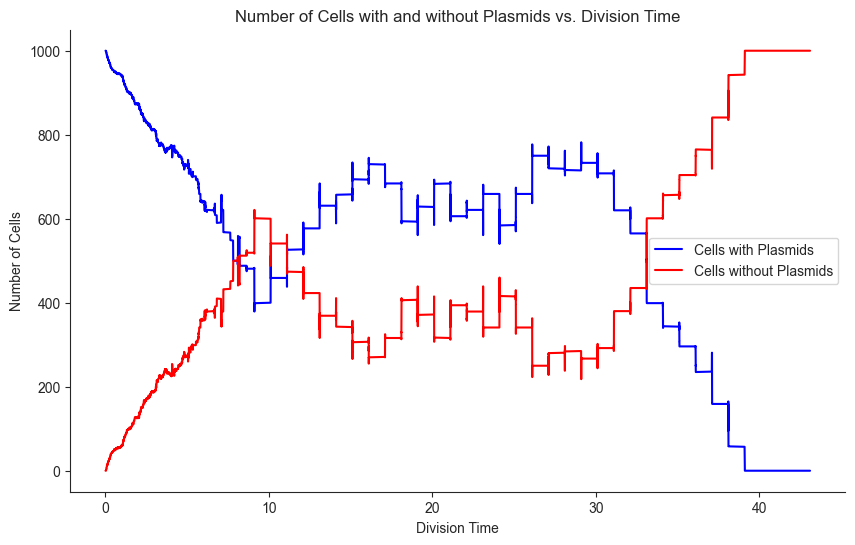

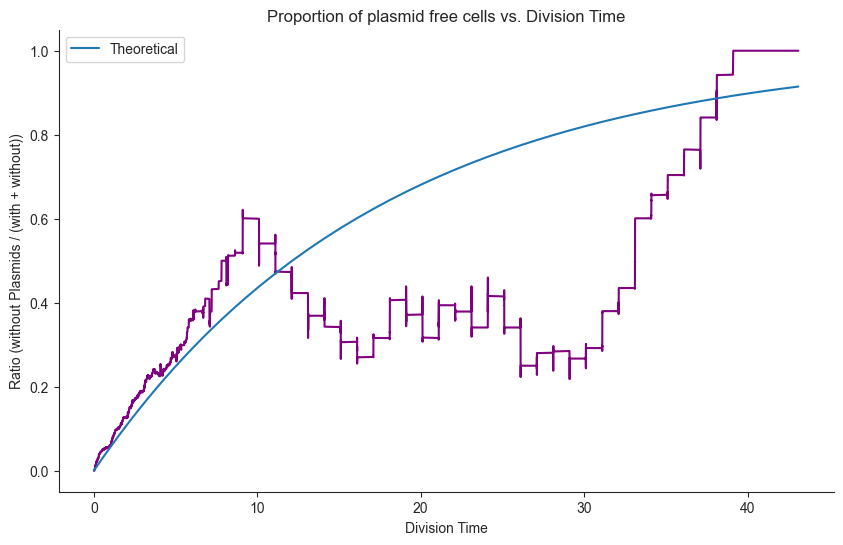

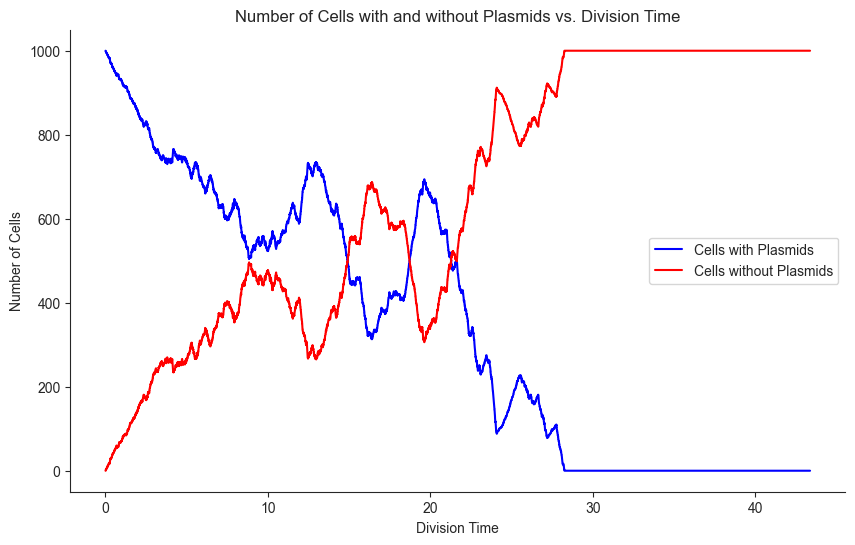

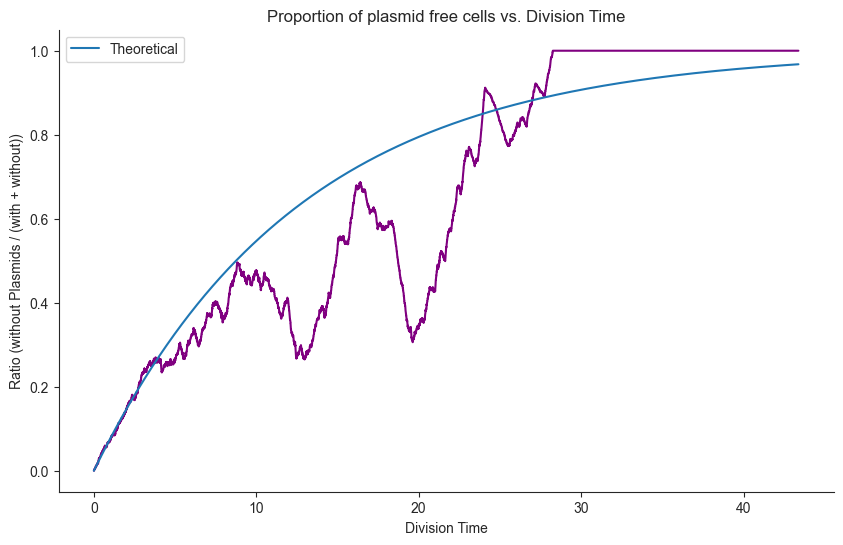

In [26]:
#Spatial model with delta distributed division times
plot_plasmid_counts_loc(cells_with_plasmids_historyloc, cells_without_plasmids_historyloc)

#Spatial model with exponentially distributed division times

plot_plasmid_counts_locexp(cells_with_plasmids_historylocexp, cells_without_plasmids_historylocexp)

In [27]:
loops_long=1000
timevecdelta_long=[]
timevecexp_long=[]
for i in range(loops_long):
    Qloc, cellsloc,cells_with_plasmids_historyloc, cells_without_plasmids_historyloc,countlossloc,countplasloc,losstimesloc,divisiontimesloc, timeloc = simulation_spatial_delta(Nmax, keep, a_w, a_m, n, p)
    timevecdelta_long.append(timeloc)

for j in range(loops_long):
    Qlocexp, cellslocexp,cells_with_plasmids_historylocexp, cells_without_plasmids_historylocexp,countlosslocexp,countplaslocexp,losstimeslocexp,divisiontimeslocexp, timelocexp = simulation_spatial_exp(Nmax, keep, a_w, a_m, n, p)
    timevecexp_long.append(timelocexp)

import dill
dill.dump_session('Spatial-plasmid-openends-TIMEDIST.pkl')

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6., 23., 30., 49., 58.,
        57., 42., 56., 53., 57., 57., 32., 39., 26., 39., 23., 33., 27.,
        23., 21., 23., 27., 18., 17., 21., 10.,  6., 11., 11., 11.,  6.,
         3.,  7.,  5.,  8.,  2.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <BarContainer object of 50 artists>)

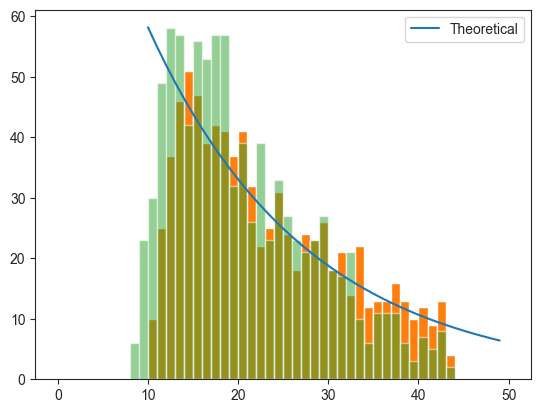

In [28]:
sns.lineplot(x=range(10,50), y=[.11/2*1000*(1-.11/2)**((x-10)-1) for x in range(10,50)], label = "Theoretical")

plt.hist(timevecdelta_long,bins=50,range=[0,50])
plt.hist(timevecexp_long,bins=50,range=[0,50],alpha=.5)